In [316]:
import numpy as np
import io
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import csv
import pandas as pd
from google.colab import auth
from gspread_dataframe import set_with_dataframe
import gspread
from oauth2client.client import GoogleCredentials


In [317]:
class CovidData:
    def __init__(self):
        self.master_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"
        self.dfLast = None
        self.dfBeforeLast = None
        self.last = None
        self.beforeLast = None
    
    def getLastTwoDays(self):
        self.last = datetime.date.today()
        self.beforeLast = self.last - datetime.timedelta(days=1)
        
        urlLast = self.master_url + self.last.strftime("%m-%d-%Y") + ".csv"
        request = requests.get(urlLast)
        #Ищем последнюю запись
        while request.status_code != 200:
          self.last = self.last - datetime.timedelta(days=1)
          self.beforeLast = self.last - datetime.timedelta(days=1)
          urlLast = self.master_url + self.last.strftime("%m-%d-%Y") + ".csv"
          request = requests.get(urlLast)
        urlBeforeLast = self.master_url + self.beforeLast.strftime("%m-%d-%Y") + ".csv"
        self.dfLast = pd.read_csv(urlLast)
        self.dfBeforeLast = pd.read_csv(urlBeforeLast)


    def getCasesDiff(self):
      rowNumLast = self.dfLast.loc[self.dfLast['Province_State'] == 'Novosibirsk Oblast' ].index[0]
      rowLast = self.dfLast.iloc[rowNumLast]
      rowNumBeforeLast = self.dfBeforeLast.loc[self.dfBeforeLast['Province_State'] == 'Novosibirsk Oblast' ].index[0]
      rowBeforeLast = self.dfBeforeLast.iloc[rowNumBeforeLast]
      return rowLast["Confirmed"] - rowBeforeLast["Confirmed"]




In [318]:
n = CovidData()

n.getLastTwoDays()

print("Прирост заболевших c в новосибирской области: "+ n.beforeLast.strftime("%m-%d-%Y") + " до " + n.last.strftime("%m-%d-%Y") + ": " + str(n.getCasesDiff()))

Прирост заболевших c в новосибирской области: 04-28-2021 до 04-29-2021: 74


In [322]:
auth.authenticate_user()

filename = 'Covid'

gc = gspread.authorize(GoogleCredentials.get_application_default())

try:
    spreadsheet = gc.open(filename)
except gspread.SpreadsheetNotFound:
    spreadsheet = gc.create(filename)

#filling first sheet for reference purposes
worksheet1 = spreadsheet.sheet1

worksheet1.clear()
set_with_dataframe(worksheet1, n.dfLast)



dfCopy = n.dfLast

# getting rid of non russia entries
dfCopy.drop(dfCopy.loc[dfCopy['Country_Region'] != "Russia"].index,inplace=True)

# Greating pivot table
pivotTable = pd.pivot_table(dfCopy, index='Province_State', columns='Country_Region', values='Confirmed').reset_index()
# adding row with total sum

pivotTable.loc["Total"]= ["Total",dfCopy['Confirmed'].sum()]


worksheet2 = spreadsheet.get_worksheet(1)
if worksheet2== None:
  spreadsheet.add_worksheet(title="Pivot Table", rows="100", cols="20")
  worksheet2 = spreadsheet.get_worksheet(1)
else:
  worksheet2.clear()
set_with_dataframe(worksheet2, pivotTable)




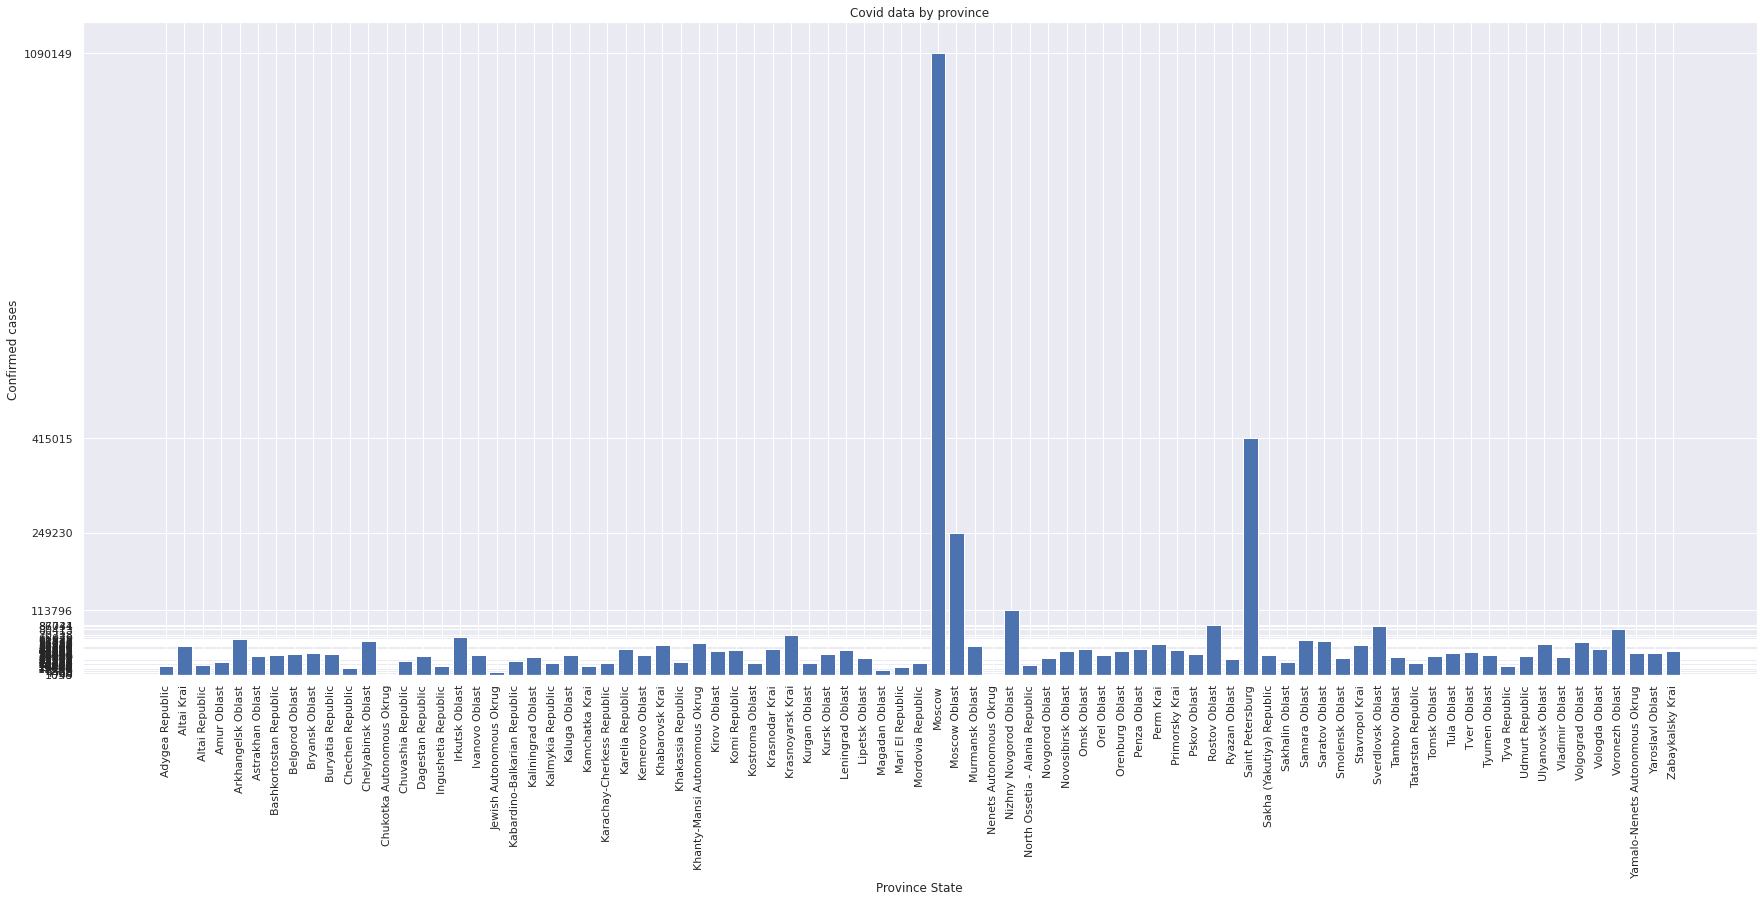

In [323]:
vertical = dfCopy['Confirmed'].values
horizontal = dfCopy["Province_State"].values
y_pos = range(len(horizontal))


fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(111)
rects1 = ax.bar(horizontal, vertical)
plt.xlabel("Province State")
plt.ylabel("Confirmed cases")
plt.title("Covid data by province")

plt.xticks(horizontal, horizontal, rotation='vertical')
plt.yticks(vertical)



plt.show()
